# Classification of hand gestures with ResNet
This project is one of my assignments from the [Deep Learning Specialization course](https://www.coursera.org/specializations/deep-learning).

In [1]:
import numpy as np
import h5py

##  Data preparation

In [2]:
# Load the dataset

def load_dataset():
    train_dataset = h5py.File('./data/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('./data/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize data
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one-hot encoded matrices
Y_train = np.eye(6)[Y_train_orig.reshape(-1)]
Y_test = np.eye(6)[Y_test_orig.reshape(-1)]

## Model architecture 

In [4]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.initializers import glorot_uniform

Using TensorFlow backend.


In [5]:
# Create ResNet identity block

def identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve filters size
    F1, F2, F3 = filters
    
    # Build identity block 
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [6]:
# Create ResNet convolutional block 

def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # Define name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve filters size
    F1, F2, F3 = filters
    
    # Build convolutional block
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, (f, f), strides=(1,1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1,1), strides=(1,1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    X_shortcut = Conv2D(F3, (1,1), strides=(s,s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base +'1')(X_shortcut)

    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [7]:
# Build ResNet model

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block='b')
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block='c')
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a')
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='b')
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='c')
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='d')
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='e')
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a')
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block='b')
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [8]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

## Training and testing 

In [9]:
# Compile the model 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model 
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
1080/1080 [==============================] - 71s 66ms/step - loss: 1.7110 - accuracy: 0.4750
Epoch 2/2
1080/1080 [==============================] - 60s 56ms/step - loss: 0.5836 - accuracy: 0.7972


In [11]:
# Evaluate the model on the test set 
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 2s 16ms/step
Loss = 3.9948134740193684
Test Accuracy = 0.1666666716337204


##  Testing on pretrained model 

In [12]:
# Load pretrained model 
model = load_model('./model/ResNet50.h5') 

/Applications/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [13]:
# Evaluate pretrained model on the test set 
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 2s 21ms/step
Loss = 0.5301785508791605
Test Accuracy = 0.8666666746139526


In [14]:
from matplotlib.pyplot import imshow
import scipy.misc
from PIL import Image
%matplotlib inline

In [15]:
def inference(path):
    # Load the image 
    my_image = Image.open(path)
    imshow(my_image)

    # Preprocess the image to coincide with model input size
    img = image.load_img(path, target_size=(64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # Predict the class
    predictions = model.predict(x)

    print('\nPredicted class: ', np.argmax(predictions))


Predicted class:  2


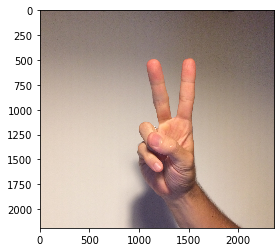

In [16]:
inference('./test/2.jpg')


Predicted class:  5


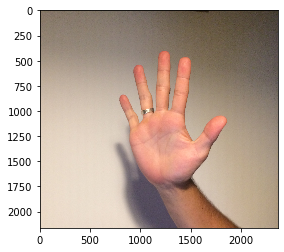

In [17]:
inference('./test/5.jpg')